In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/klasifikasi_songket

/content/gdrive/My Drive/klasifikasi_songket


In [3]:
! ls

 dataset_songket	   songketa_model.h5		 'test_image_songketa (3).jpg'
 dataset_split		  'test_image_songketa (1).jpg'   test_image_songketa.jpg
 pucukRebung_riau_22.jpg  'test_image_songketa (2).jpg'   test_songketa2.jpg


Read Random Data

In [4]:
from PIL import Image
import os
import numpy as np
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Ukuran gambar:{img.shape}")
  return img

Ukuran gambar:(224, 224, 3)


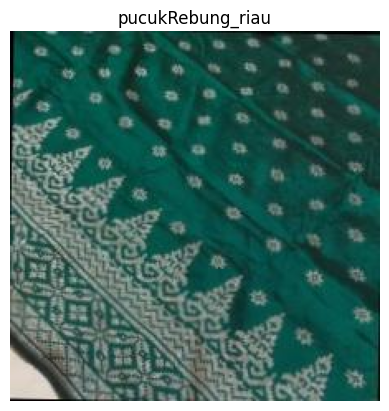

In [6]:
img = view_random_image("dataset_split/train/", "pucukRebung_riau")

Data Preprocessing

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
base_dir = '/content/gdrive/My Drive/klasifikasi_songket/dataset_split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [10]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=20)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size=(224,224),
                                                    class_mode='categorical',
                                                    batch_size=20)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  batch_size=20)

Found 366 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 79 images belonging to 4 classes.


In [11]:
classes=list(train_generator.class_indices.keys())
print (classes)
class_count=len(classes)

['bunga_palembang', 'pucukRebung_riau', 'sirangkak_sumateraBarat', 'subahnale_lombok']


Build Model

In [12]:
base_model=tf.keras.applications.mobilenet.MobileNet(include_top=False,
                                                     weights="imagenet",
                                                     input_shape=(224, 224, 3))

#base_model.summary()

base_model.trainable = False

model = tf.keras.models.Sequential([
            base_model,
            tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', strides=1),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4, activation='softmax')
])

#model.summary()

17225924/17225924 [==============================] - 2s 0us/step


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/50
19/19 [==============================] - 198s 10s/step - loss: 1.3665 - accuracy: 0.6557 - val_loss: 0.2962 - val_accuracy: 0.8861
Epoch 2/50
19/19 [==============================] - 1s 71ms/step - loss: 0.2300 - accuracy: 0.9262 - val_loss: 0.1754 - val_accuracy: 0.9620
Epoch 3/50
19/19 [==============================] - 2s 86ms/step - loss: 0.0821 - accuracy: 0.9754 - val_loss: 0.1916 - val_accuracy: 0.9494
Epoch 4/50
19/19 [==============================] - 2s 87ms/step - loss: 0.0633 - accuracy: 0.9809 - val_loss: 0.1544 - val_accuracy: 0.9494
Epoch 5/50
19/19 [==============================] - 2s 83ms/step - loss: 0.0406 - accuracy: 0.9863 - val_loss: 0.1180 - val_accuracy: 0.9620
Epoch 6/50
19/19 [==============================] - 1s 69ms/step - loss: 0.0346 - accuracy: 0.9836 - val_loss: 0.3089 - val_accuracy: 0.9241
Epoch 7/50
19/19 [==============================] - 1s 71ms/step - loss: 0.0375 - accuracy: 0.9836 - val_loss: 0.1780 - val_accuracy: 0.9747
Epoch 8/50
1

Class Accuracy

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)
predictions = model.predict(test_generator)
class_labels = list(test_generator.class_indices.keys())
class_accuracies = []

for i, class_label in enumerate(class_labels):
    class_index = test_generator.class_indices[class_label]
    class_predictions = predictions[:, class_index]
    true_labels = (test_generator.labels == class_index).astype(int)
    class_accuracy = np.sum(np.round(class_predictions) == true_labels) / len(true_labels)
    class_accuracies.append((class_label, class_accuracy))

for class_label, class_accuracy in class_accuracies:
    print(f'Accuracy for class {class_label}: {class_accuracy * 100:.2f}%')


4/4 [==============================] - 1s 56ms/step
Accuracy for class bunga_palembang: 58.23%
Accuracy for class pucukRebung_riau: 65.82%
Accuracy for class sirangkak_sumateraBarat: 59.49%
Accuracy for class subahnale_lombok: 74.68%


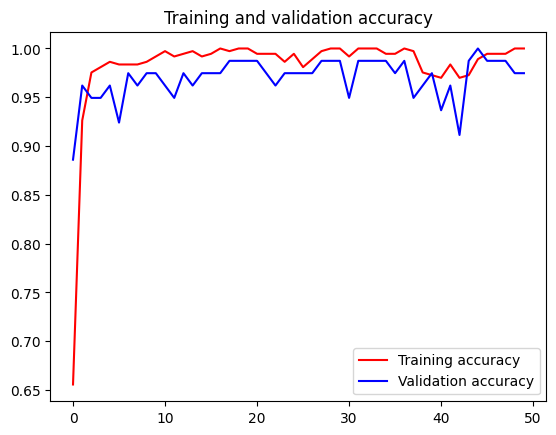

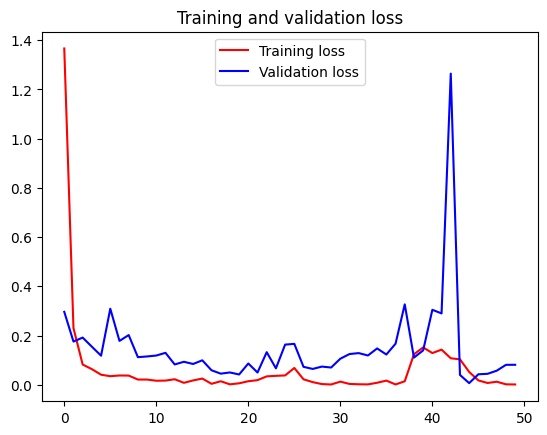

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

Save Model

In [ ]:
model.save("songketa_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Predict Image

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

model = load_model('songketa_model.h5')

In [30]:
img_path = '/content/cat.jpeg'

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Prediksi kelas
predictions = model.predict(img_array)
class_index = np.argmax(predictions, axis=1)

# Mapping indeks kelas ke label kelas
class_labels = {0: 'bunga_palembang', 1: 'pucukRebung_riau', 2: 'sirangkak_sumateraBarat', 3: 'subahnale_lombok'}
predicted_class = class_labels[class_index[0]]

# Set a threshold value (adjust as needed)
threshold = 0.7

# Check if the maximum confidence score is above the threshold
if np.max(predictions) > threshold:
    print(f'Predicted class: {predicted_class}')
else:
    print('The item is not classified as songket.')

1/1 [==============================] - 0s 21ms/step
The item is not classified as songket.
